# Data Exploration

In [3]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.corpus import stopwords
import re

TRAIN_PATH = "./data/train.csv"
STOP = set(stopwords.words('english'))

In [80]:
df = pd.read_csv(TRAIN_PATH)
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [12]:
print("Number of empty keyword cells:", df["keyword"].isna().sum())
print("Number of empty location cells:", df["location"].isna().sum())
print("Mean tweet length:", df["text"].str.len().mean())
print("Tweet length standard deviation:", df["text"].str.len().std())
print(df["target"].value_counts(normalize=True))

Number of empty keyword cells: 61
Number of empty location cells: 2533
Mean tweet length: 101.03743596479706
Tweet length standard deviation: 33.78132502563203
0    0.57034
1    0.42966
Name: target, dtype: float64


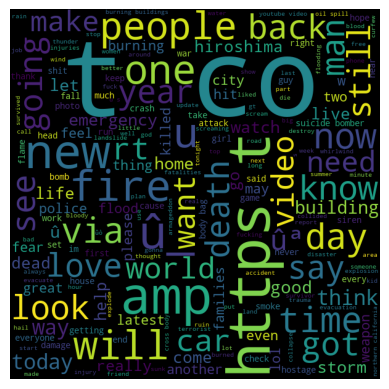

In [6]:
words = ''
for tweet in df["text"]:
    tweet = tweet.lower()
    words += tweet + ' '
wordcloud = WordCloud(width=600, height=600).generate(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

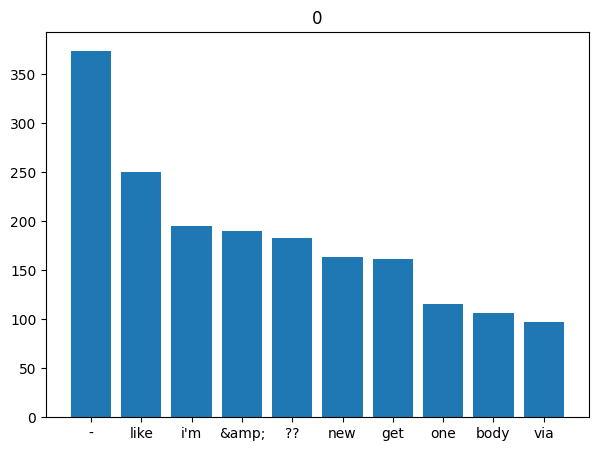

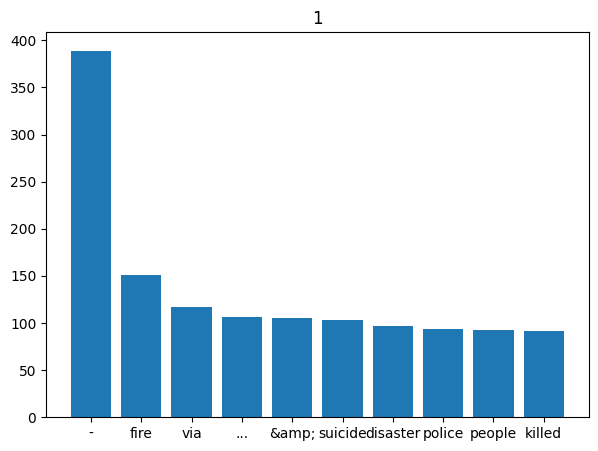

In [9]:
def plot_top_n_words(label, plot_stop=False):
    corpus = []
    for _, row in df[df['target'] == label].iterrows():
        lst = row[3].split()
        for w in lst:
            corpus.append(w.lower())
    
    corpus_dict = defaultdict(int)
    for word in corpus:
        if plot_stop:
            corpus_dict[word] += 1
        elif not plot_stop and word not in STOP:
            corpus_dict[word] += 1
    top_n = 10
    top = sorted(corpus_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    x, y = zip(*top)
    plt.figure(figsize=(7,5))
    plt.title(label)
    plt.bar(x, y)
    plt.show()

plot_top_n_words(label=0)
plot_top_n_words(label=1)

# Data Cleaning

In [81]:
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")

LEM = WordNetLemmatizer()

def clean_text(t):
    t = re.sub(r"&(amp;)+", "&", t)
    t = re.sub(r"[^\w\s*|&]|http\S+|Û_", " ", t)
    t = t.lower()
    lst = [word for word in t.split() if word not in STOP]
    lst = [LEM.lemmatize(word) for word in lst]
    t = " ".join(lst)
    return t

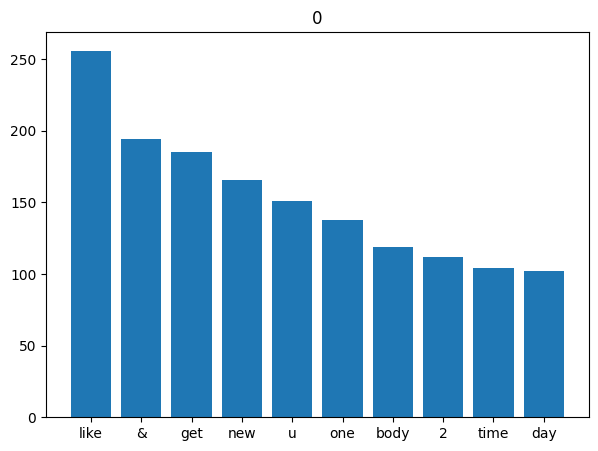

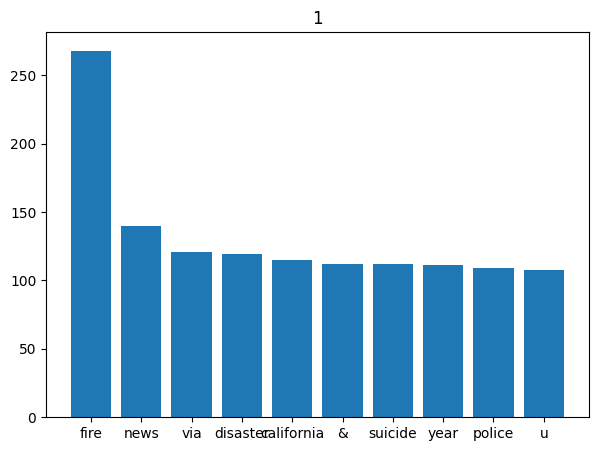

In [82]:
df["text"] = df["text"].apply(lambda x: clean_text(x))
plot_top_n_words(label=0)
plot_top_n_words(label=1)

# Model

In [15]:
import torch
torch.cuda.current_device()

AssertionError: Torch not compiled with CUDA enabled

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size) -> None:
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.in2hi = nn.Linear()
        
        self.hi2ou = nn.Linear()